<a href="https://colab.research.google.com/github/whitejetyeh/RBMIsing/blob/master/RBMrecommend(July_19).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RBMrecommend

Restrictive Boltzmann Machine (RBM) is an unsupervised learning, which automatically extracts features of stochastic binary distributions. Its application for collaborative filtering is in the leading position in the [Netflix prize](https://www.netflixprize.com/), see [Salakhutdinov et al., 2007](https://www.cs.toronto.edu/~rsalakhu/papers/rbmcf.pdf). Similar to recommend new movies to audiences according to their viewing record, by implementing RBM, this project RBMrecommend builds a recommendation system that automatically sorts products regarding their intrinsic features and classifies customers with feature preferences. 

Neither features of a product nor the preference of a customer is provided in the dataset. Data recorded purchased items of a customer, and RBMrecommend predicts whether the customer will buy another product based on his and other customers' purchase histories, i.e., collaborative filtering.

RBM, in short, is a dynamical system of binary nodes on two layers, see ![pic](https://drive.google.com/open?id=1I6hbFZ9V3u8iKXpPVOqWJDcq4lvAPjF4). The system is determined by the energy
$$E(v,h)=-b^{(v)}_iv^i-b^{(h)}_jh^j-v^iW_{ij}h^j,$$
and the system has the probability 
$$p(v,h)=\frac{e^{-E(v,h)}}{\sum\limits_{v,h}e^{-E(v,h)}}$$
to be observed at the $(v,h)$ distribution of turned on nodes.
Given a dataset $D$, the parameters $b^{(v)}$, $b^{(h)}$, and $W$ are molded by the general features of $D$ such that much frequently appearing patterns will have higher probabilities. An introduction of RBM can be found in [RBMIsing](https://colab.research.google.com/drive/1kEoVz9gX-RKd6VXEmARyT5RmSOA1ah3q#scrollTo=gf3xHXYRou0M).

After training the RBM with the dataset $D$, one can feed the RBM with an input $V$, and $V$ in the RBM will evolve into $\overline{V}$, which can be recognized in one reapperaing patterm similar to $V$. In this way, RBMrecommend automatically recognize a product's features and a customer's preferences from the customer's purchase history, and RBMrecommend can suggest an unknown product to the customer according to his taste.


## Data generation

To get an idea about how well RBMrecommend learns, we generated our data set artificially. We created a market of items with given performance on several features, and we know exactly how much does each customer value every feature.
For example, consider 10,000 customers in a market with 100 items, and each item has scores of 5 features, we have the product profile as
$$P=\begin{array}{cccccc}
 && \textrm{item}_1& \textrm{item}_2& \dots& \\
 \begin{array}{c}\textrm{feature}_A\\\textrm{feature}_B\\\vdots\end{array}&\Bigg(&\begin{array}{c}1\\3\\\vdots\end{array}&\begin{array}{c}2\\4\\\vdots\end{array}& \begin{array}{c}\dots\\\dots\\\ddots\end{array}&\Bigg) 
\end{array}$$
and the customer profile as
$$C=\begin{array}{cccccc}
 && \textrm{frature}_A& \textrm{frature}_B& \dots& \\
 \begin{array}{c}\textrm{customer}_1\\\textrm{customer}_2\\\vdots\end{array}&\Bigg(&\begin{array}{c}0.1\\0.5\\\vdots\end{array}&\begin{array}{c}0.7\\0.3\\\vdots\end{array}& \begin{array}{c}\dots\\\dots\\\ddots\end{array}&\Bigg) 
\end{array}.$$

The items are purchased regarding to the scores in
$$D_V=CP=\begin{array}{cccccc}
 && \textrm{item}_1& \textrm{item}_2& \dots& \\
 \begin{array}{c}\textrm{customer}_1\\\textrm{customer}_2\\\vdots\end{array}&\Bigg(&\begin{array}{c}2.2\\1.4\\\vdots\end{array}&\begin{array}{c}3\\2.2\\\vdots\end{array}& \begin{array}{c}\dots\\\dots\\\ddots\end{array}&\Bigg) 
\end{array}.$$
A customer randomly chooses to buy 10 items with high scores and to ignore other 10 items with low scores, and he is not aware of the rest items. 

Nevertheless, these profiles P and C are kept for evaluating our RBM but not provided for training. Just like an online marketplace, the dataset records a customer purchased an item or he browse other items without buying. The training dataset provided for RBMrecommend may look like
$$D_T=\begin{array}{cccccc}
 && \textrm{item}_1& \textrm{item}_2& \dots& \\
 \begin{array}{c}\textrm{customer}_1\\\textrm{customer}_2\\\vdots\end{array}&\Bigg(&\begin{array}{c}1\\?\\\vdots\end{array}&\begin{array}{c}1\\0\\\vdots\end{array}& \begin{array}{c}\dots\\\dots\\\ddots\end{array}&\Bigg) 
\end{array},$$
where the entries $(1,0,?)$ stand for (like, dislike, unknown) respectively.

**In reality, one does not know how to recognize features of items, or an item's score in a feature, or how a customer value different features.
However, RBMrecommend is trained to recover the unknown entries in $D_{T}$ based on purchase record, so a customer learns if he will like an unknown item, and one learns a new product similar to some items will be popular or not.**

Firstly, we explicitly generate the profiles of customers and products in the following code.


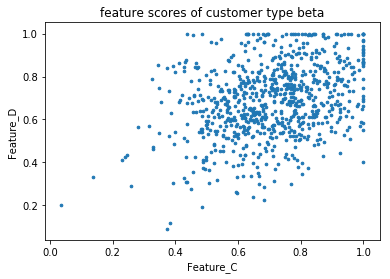

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: covariance is not symmetric positive-semidefinite.


In [0]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

''' create customer profiles '''
ppl_number = 2000

# alpha type interests in three features
temp_mean = [0.8,0.7,0.6]
temp_cov = [[0.05,0,0],[0,0.02,0],[0,0,0.03]] # std for 3 independent features
temp_size = int(0.6*ppl_number) # 60% population
np.random.seed(1)

temp_score = np.random.multivariate_normal(temp_mean,temp_cov,temp_size)
for f in range(3):
    np.clip(temp_score[:,f],0,1,out=temp_score[:,f]) #bound normal distribution

temp_data = {'type':['alpha']*temp_size,'F_A':temp_score[:,0],
             'F_B':temp_score[:,1],'F_C':temp_score[:,2],
             'F_D':[0]*temp_size,'F_E':[0]*temp_size}
profile_C = pd.DataFrame(temp_data)

# beta type interests in two features
temp_mean = [0.7,0.7]
temp_cov = [[0.03,0.01],[0.01,0.03]] # std for 2 dependent features
temp_size = int(0.4*ppl_number) # 40% population
np.random.seed(2)

temp_score = np.random.multivariate_normal(temp_mean,temp_cov,temp_size)
for f in range(2):
    np.clip(temp_score[:,f],0,1,out=temp_score[:,f]) #bound normal distribution

temp_data = {'type':['beta']*temp_size,'F_A':[0]*temp_size,
             'F_B':[0]*temp_size,'F_C':temp_score[:,0],
             'F_D':temp_score[:,1],'F_E':[0]*temp_size}
profile_C = pd.concat([profile_C,pd.DataFrame(temp_data)]).reset_index(drop=True)

# shuffle
profile_C = profile_C.reindex(np.random.permutation(profile_C.index))

# graphical output for illustration
plt.scatter(temp_score[:, 0], temp_score[:, 1], s=7, cmap='autumn')
plt.title('feature scores of customer type beta')
plt.xlabel('Feature_C')
plt.ylabel('Feature_D')
plt.show()

''' create product profiles '''
item_number = 100

# P_I type with three features
temp_mean = [0.4,0.3,0.3]
temp_cov = [[0.1,0,0],[0,0.02,0],[0,0,0.03]] # std for 3 independent features
temp_size = int(0.5*item_number) # 50% of products
np.random.seed(3)

temp_score = np.random.multivariate_normal(temp_mean,temp_cov,temp_size)
for f in range(3):
    np.clip(temp_score[:,f],0,1,out=temp_score[:,f]) #bound normal distribution

temp_data = {'type':['P_I']*temp_size,'F_A':temp_score[:,0],
             'F_B':temp_score[:,1],'F_C':temp_score[:,2],
             'F_D':[0]*temp_size,'F_E':[0]*temp_size}
profile_P = pd.DataFrame(temp_data)

# P_II type with two features
temp_mean = [0.6,0.4]
temp_cov = [[0.02,0.03],[0.03,0.02]] # std for 2 dependent features
temp_size = int(0.4*item_number) # 40% of products
np.random.seed(4)

temp_score = np.random.multivariate_normal(temp_mean,temp_cov,temp_size)
for f in range(2):
    np.clip(temp_score[:,f],0,1,out=temp_score[:,f]) #bound normal distribution

temp_data = {'type':['P_II']*temp_size,'F_A':[0]*temp_size,
             'F_B':[0]*temp_size,'F_C':temp_score[:,0],
             'F_D':temp_score[:,1],'F_E':[0]*temp_size}
profile_P = pd.concat([profile_P,pd.DataFrame(temp_data)]).reset_index(drop=True)

# P_III type with one feature
temp_mean = 0.8
temp_cov = 0.1 # std for a features
temp_size = int(0.1*item_number) # 10% of products
np.random.seed(5)

temp_score = np.random.normal(temp_mean,temp_cov,temp_size)
np.clip(temp_score,0,1,out=temp_score) #bound normal distribution

temp_data = {'type':['P_III']*temp_size,'F_A':[0]*temp_size,
             'F_B':[0]*temp_size,'F_C':[0]*temp_size,
             'F_D':[0]*temp_size,'F_E':temp_score}
profile_P = pd.concat([profile_P,pd.DataFrame(temp_data)]).reset_index(drop=True)

# shuffle
profile_P = profile_P.reindex(np.random.permutation(profile_P.index))

In summery, 2000 customers and 100 products are divided into types $\alpha$ & $\beta$ and types I, II, & III as the following.

\begin{array}{ |c|c|c|c|c|c| }
\hline
\textrm{class\feature}&A&B&C&D&E\\
\hline
\alpha (60\%) &0.8&0.7&0.6&0&0\\\hline
\beta (40\%)&0&0&0.7&0.7&0\\\hline
I(50\%)&0.4&0.3&0.3&0&0\\\hline
II(40\%)&0&0&0.6&0.4&0\\\hline
III(10\%)&0&0&0&0&0.8\\\hline
\end{array}
In each class, customers or products have scores of a feature in normal distribution with the nonzero mean given in the table.

For example, 40% of customers are type $\beta$ interested in the features C & D, see the above plot, and the type II products are their favorite.
Notice that a customer could have very low interests in any features. Low interested customers have low resolutions in products, i.e., they don't care much what they bought.
All scores are scaled and bounded within [0,1] for training. 

Therefore, we anticipate that RBMrecommend predicts customers' interest in different products as the following.
\begin{array}{ |c|c|c|c| }
\hline
\textrm{customer\product}&I(50\%)&II(40\%)&III(10\%)\\
\hline
\alpha (60\%) &\textrm{high}&\textrm{low}&\textrm{reject}\\\hline
\beta (40\%)&\textrm{low}&\textrm{high}&\textrm{reject}\\\hline
\end{array}

The training data consists of every customer's records over random 20 items. A customer records 1 if the item scores over 0.5 for him, otherwise 0. The rest 80 items are unknown to the customer.

In [0]:
''' generate validation dataset;
index/column refers to the customer/item'''
start = time.time() # timing data generation

# validation = D_V
# interest score is clipped in [0,1].
validation = profile_C.loc[:,'F_A':'F_E'].dot(profile_P.loc[:,'F_A':'F_E'].T).clip(0,1)

# label 1 for scores higher than 0.5 else label 0
validation_label = validation.applymap(lambda x:1 if x>0.5 else 0)

print('Top rows of validation (D_V)')
print(validation.head())

''' generate train/test dataset;
index/column refers to the customer/item ID'''
# create null raw data in the same shape as validation
raw_data = pd.DataFrame(index=validation.index, columns=validation.columns)

# randomly fill training data w.r.t validation_label
for i in range(ppl_number):
    #randomly choose 20 entries out of validation_label in every row
    temp_index = np.random.choice(item_number,20,replace=False)
    raw_data.iloc[i,temp_index] = validation_label.iloc[i,temp_index]

# split raw data into test and train subsets
train_test_split = int(0.8*ppl_number)
train_data = raw_data.iloc[:train_test_split]
test_data = raw_data.iloc[train_test_split:]
# validation labels
train_label = validation_label.iloc[:train_test_split]
test_label = validation_label.iloc[train_test_split:]
end = time.time() # timing data generation

print('\n It takes ',end-start,'secs to generate data of ',ppl_number,'customers.')

print('\n Top rows of training data (D_T)')
print(train_data.head())

Top rows of validation (D_V)
            71        59        39  ...        75        77        44
1582  0.821877  0.444590  0.089763  ...  0.432777  0.718286  0.121182
885   0.710753  0.427727  1.000000  ...  0.302238  0.643758  1.000000
1772  1.000000  0.556392  0.103074  ...  0.562881  0.907728  0.139151
42    0.534996  0.321958  0.916180  ...  0.227500  0.484568  0.996947
1306  1.000000  0.602196  0.136790  ...  0.551273  0.958447  0.184668

[5 rows x 100 columns]

 It takes  11.666318416595459 secs to generate data of  2000 customers.

 Top rows of training data (D_T)
       71   59   39   10   93   23   57  ...   84   30   47   65   75   77   44
1582  NaN  NaN  NaN  NaN  NaN  NaN    1  ...  NaN  NaN    0  NaN  NaN  NaN  NaN
885   NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN    1    1  NaN  NaN  NaN
1772  NaN  NaN  NaN  NaN    0  NaN  NaN  ...  NaN  NaN  NaN  NaN    1  NaN  NaN
42    NaN  NaN  NaN  NaN    0  NaN  NaN  ...  NaN  NaN    1    0    0  NaN  NaN
1306  NaN  NaN  NaN 

## RBM training

A short introduction of RBM and the python code below can be found in [RBMIsing](https://colab.research.google.com/drive/1kEoVz9gX-RKd6VXEmARyT5RmSOA1ah3q#scrollTo=gf3xHXYRou0M). The code has been modified slightly to deal with the missing entries in the dataset.

The common solution of missing data is to impute random values because the contribution from random values will eventually be even out after enough iterations in the Monte Carlo method.
However, missing values consist of the major part in the recommender system, instead of imputing missing values, we choose to disconnect the missing visible nodes, see [Hinton, 2010](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf). 
As shown in ![pic](https://drive.google.com/open?id=1MmE1LrkYXd85WoY-bUXtFDwG24hGVHtR), the visible nodes missing data are isolated with no coupling to the hidden nodes. 


### Python code for RBM
RBMcdk is a class defined for restrictive boltzmann machine with CD-k method. 
One builds a model X with V and H variables in visible and hidden layers respectively by 

```
X = RBMcdk(V,H).
```
The input data D with N samples of V-dimensional arrays shall be shaped as a 2D-array of (dim_0=N, dim_1=V).
With CD-k method, one then trains the model X in N epochs with learning rate L by

```
X.contrastive_divergence(D,iterations=N,k=k).
```

After X is trained, Nd samples in a dataset Dd (dim_0=Nd, dim_1=V) can be processed into reconstructed Dd_recon by kd Gibbs steps with X by

```
Dd_recon = gibbs_sampling(Dd, X, k=kd, return_state).
```

For *return_state = V_gibbs, H_gibbs, or H_data*,  *gibbs_sampling* returns the gibbs visual state $v^{(k)}$, the gibbs hidden state $h^{(k)}$, or the data driven hidden state $h^{(0)}$ respectively.




In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.special import expit # sigmoid

# Functions useful in RBM
def cond_prob(states, weight, bias):
        # conditional probability
        Nsamples = len(states)
        stacked_bias = np.stack([bias for _ in range(Nsamples)],axis=0)
        return expit(np.matmul(states, weight) + stacked_bias)
    
def MC_selection(probabilities):
        # stochastically sample binary values with given probabilities
        # compare probabilities P with a random tensor T in the same shape; 
        # return 1 for P > T or 0 for P <= T; P must be in [0,1].
        coins = np.random.uniform(0,1,np.shape(probabilities))
        return np.ceil(probabilities-coins)
      
def gibbs_sampling(dataframe, trained_rbm, k=1, return_state='V_gibbs',probability=False):    
    '''adaption of missing data(NaN);
       Input data was changed from ndarray to pandas' dataframe;
       Modified lines are attached by comment #missing_data_adaption. '''
    # data input = [v1,v2,...,vN] for N samples, v_dim = [visible_dim]
        
    # replace NaN in the dataframe by 0
    data = dataframe.fillna(0).values #missing_data_adaption
        
    # data driven hidden layer
    hidden_state = MC_selection(cond_prob(data, 
                                          trained_rbm.weight, 
                                          trained_rbm.hidden_bias)) 
            
    #Gibbs sampling iteration for data reconstruction
    #CD1
    visible_gibbstate = cond_prob(hidden_state, 
                                  np.transpose(trained_rbm.weight), 
                                  trained_rbm.visible_bias)
    hidden_gibbstate = cond_prob(visible_gibbstate, 
                                 trained_rbm.weight, 
                                 trained_rbm.hidden_bias)
    #CDK>1
    for j in range(k-1):        
        visible_gibbstate = cond_prob(hidden_gibbstate, 
                                      np.transpose(trained_rbm.weight), 
                                      trained_rbm.visible_bias)
        hidden_gibbstate = cond_prob(visible_gibbstate, 
                                     trained_rbm.weight, 
                                     trained_rbm.hidden_bias)
    # reconstructed layers
    if probability:
        visible_gibbstate = visible_gibbstate
        hidden_gibbstate = hidden_gibbstate
    else:        
        visible_gibbstate = MC_selection(visible_gibbstate)
        hidden_gibbstate = MC_selection(hidden_gibbstate)
    
    if return_state == 'V_gibbs':
        return visible_gibbstate
    elif return_state == 'H_gibbs':
        return hidden_gibbstate
    elif return_state == 'H_data':
        return hidden_state
    else:
        print('calling invalid return_state')
        return visible_gibbstate
      
# statistical error in the hypothesis test
def stat_error(prediction,validation):
    # input two same dimensional pd.dataframes
    F_N = np.nansum(validation.where(prediction != validation)) #False negative
    F_P = np.nansum(0==validation.where(prediction != validation)) #False positive
    N = validation.size
    return (F_N+F_P)/N
      
# Building RBM
class RBMcdk:
    '''Restrctive Boltzmann Machine with CD_k method'''
    def __init__(self, visible_dim, hidden_dim): 
      
        #initialize weight and biases
        np.random.seed(624) # fix the same random initial values
        self.weight = np.random.normal(loc=0,scale=0.1,size=[visible_dim, hidden_dim])
        self.visible_bias = np.random.uniform(low=0,high=1,size=[visible_dim])
        self.hidden_bias = np.random.uniform(low=0,high=1,size=[hidden_dim])
        
    
    def contrastive_divergence(self, dataframe, iterations, k=1, learning_rate=0.1, text_out=False):
        '''adaption of missing data(NaN);
        Input data was changed from ndarray to pandas' dataframe;
        Modified lines are attached by comment #missing_data_adaption. '''
        # data input = [v1,v2,...,vN] for N samples, v_dim = [visible_dim]
        
        # replace NaN in the dataframe by 0
        data = dataframe.fillna(0).values #missing_data_adaption
        
        Nsamples = len(data)
        print("Number of samples = ",Nsamples," with data dimension = ",len(data[0]))
        
        # count numbers of NaN in samples;
        # e.g., visible dot [i] missed MIN[i] samples out of N samples
        # Missing In N samples(MIN)
        MIN = dataframe.isna().values.sum(axis=0) #missing_data_adaption
        for missing in MIN:
            if missing == Nsamples:
                print('error message: no data in %d-th visual node.' % missing)
                return
        start = time.time() # timing training process
                
        
        for i in range(iterations):
                
            # initialize data-driven hidden layer
            # state dimensions = (Nsamples, layer dim)
            self.hidden_state = MC_selection(cond_prob(data, 
                                                       self.weight, 
                                                       self.hidden_bias)) 
            
            #Gibbs sampling iteration
            #CD1
            self.visible_gibbstate = cond_prob(self.hidden_state, 
                                               np.transpose(self.weight), 
                                               self.visible_bias)
            self.hidden_gibbstate = cond_prob(self.visible_gibbstate, 
                                              self.weight, 
                                              self.hidden_bias)
            #CDK>1
            for j in range(k-1):
                self.visible_gibbstate = cond_prob(self.hidden_gibbstate, 
                                                   np.transpose(self.weight), 
                                                   self.visible_bias)
                self.hidden_gibbstate = cond_prob(self.visible_gibbstate, 
                                                  self.weight, 
                                                  self.hidden_bias)
            
            # update weight and biases Contrastive Divergence
            
            # <vh>_data
            #vh_data = np.matmul(np.transpose(data),self.hidden_state)/Nsamples
            vh_data = np.matmul(np.transpose(data),self.hidden_state)/\
            (Nsamples-MIN[:,None]) #missing_data_adaption
            # <vh>_model
            vh_model = np.matmul(np.transpose(self.visible_gibbstate),
                                 self.hidden_gibbstate)/Nsamples
            self.weight += learning_rate*(vh_data-vh_model) # weight update
            
            #v_data = np.mean(data,axis=0) # <v>_data
            v_data = dataframe.mean(axis=0).values #missing_data_adaption
            v_model = np.mean(self.visible_gibbstate,axis=0) # <v>_model
            self.visible_bias += learning_rate*(v_data-v_model) # v_bias update
            
            h_data = np.mean(self.hidden_state,axis=0) # <h>_data
            h_model = np.mean(self.hidden_gibbstate,axis=0) # <h>_model        
            self.hidden_bias += learning_rate*(h_data-h_model) # h_bias update
          
        end = time.time() # timing training process
        print('training completed within ',end-start)
        
        # save trained weight and biases for big data
        if text_out:
            file_name = time.localtime(time.time()) # use mins+secs as the name
            file_name = str(file_name.tm_min)+str(file_name.tm_sec)
            path = '/content/gdrive/My Drive/IsingModel/'
                        
            file_path = path+file_name+'_weight.csv'
            with open(file_path,'wb+') as f:
                np.savetxt(f,self.weight,fmt='%g',delimiter=',')
                
            file_path = path+file_name+'_vbias.csv'
            with open(file_path,'wb+') as f:
                np.savetxt(f,self.visible_bias,fmt='%g',delimiter=',')
                
            file_path = path+file_name+'_hbias.csv'
            with open(file_path,'wb+') as f:
                np.savetxt(f,self.hidden_bias,fmt='%g',delimiter=',')
            print('Print model to %s_weight/bias.csv for big data' % (file_name,))

The error of reconstruction is computed in stat_error.

```
def stat_error(prediction,validation):
    # input two same dimensional pd.dataframes
    F_N = np.nansum(validation.where(prediction != validation)) #False negative
    F_P = np.nansum(0==validation.where(prediction != validation)) #False positive
    N = validation.size
    return (F_N+F_P)/N
```
In the sense of statistical hypothesis test, the error is defined as the ratio of the sum of false positive and false negative predictions over total predictions, where false positive/negative prediction means RBMrecommend falsely predicts 1/0.


### RBM training

With 50 hidden nodes and 500 iterations, RBMrecommend achieves 80+% accuracy after training in half a minute.

In [0]:
'''RBM training'''
# set a RBM with 100 visible nodes and 50 hidden nodes
RBMrecommend = RBMcdk(100,50)

# put data in RBM with CDk method
RBMrecommend.contrastive_divergence(train_data,iterations=400,k=2)

# error between train_label and predictions based on train_data
MC_train_label = pd.DataFrame(MC_selection(RBMrecommend.visible_gibbstate),
                              index=train_data.index,
                              columns=train_data.columns) #Monte Carlo selection
train_error = stat_error(MC_train_label,train_label)
print('Reconstructed input has error = ',train_error)

Number of samples =  1600  with data dimension =  100
training completed within  20.242817640304565
Reconstructed input has error =  0.16783125


In [0]:
'''Based on the pre-trained model above, we can add another 100 iterations to 
see the improved error for total 500 iterations.'''
# put data in RBM with CDk method
RBMrecommend.contrastive_divergence(train_data,iterations=100,k=2)

# error between train_label and predictions based on train_data
MC_train_label = pd.DataFrame(MC_selection(RBMrecommend.visible_gibbstate),
                              index=train_data.index,
                              columns=train_data.columns) #Monte Carlo selection
train_error = stat_error(MC_train_label,train_label)
print('Reconstructed input has error = ',train_error)


Number of samples =  1600  with data dimension =  100
training completed within  5.375041484832764
Reconstructed input has error =  0.16735625


Since the error isn't improved much with more iterations, the training is sufficient.

## Prediction and validation


Validation with test dataset has error =  0.174125


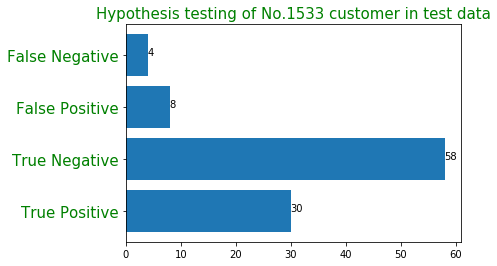

prediction error =  0.12


In [0]:
'''Validation'''
# compare prediction over test_data with validation_label
reconstruction_data = pd.DataFrame(gibbs_sampling(test_data, RBMrecommend, k=5),
                                   index=test_data.index,
                                   columns=test_data.columns)
test_error = stat_error(reconstruction_data,test_label)
print('Validation with test dataset has error = ',test_error)

# an example of predictions
C_ID = np.random.choice(test_data.index) # a random customer in test_data
temp_data = test_data.loc[C_ID].to_frame().T # visible input
temp_prediction = pd.DataFrame(gibbs_sampling(temp_data,RBMrecommend,k=10),
                               columns=temp_data.columns,index={C_ID})
temp_validation = test_label.loc[C_ID].to_frame().T
temp_probability = pd.DataFrame(gibbs_sampling(
                                temp_data,RBMrecommend,k=10,probability=True),
                                columns=temp_data.columns,index={C_ID})

# hypothesis testing
# note: df.where leaves df's entries at true and NaN at false
T_P = np.nansum(temp_validation.where(
                temp_prediction==temp_validation)).astype(int) #True positive
T_N = np.nansum(temp_validation.where(
                temp_prediction==temp_validation)==0).astype(int) #True negative
F_N = np.nansum(temp_validation.where(
                temp_prediction!=temp_validation)).astype(int) #False negative
F_P = np.nansum(temp_validation.where(
                temp_prediction!=temp_validation)==0).astype(int) #False positive

temp_statistics = [T_P,T_N,F_P,F_N]
temp_label = ['True Positive','True Negative','False Positive','False Negative']
plt.barh(temp_label, temp_statistics)
plt.yticks(temp_label,fontsize=15,color='green')
plt.title('Hypothesis testing of No.%d customer in test data' % C_ID,
          fontsize=15,color='green')
for y,x in enumerate(temp_statistics):
    plt.text(x,y,temp_statistics[y])
plt.show()

print('prediction error = ',(F_N+F_P)/item_number)

The error in the validation represents the percentage of false predictions.
The raw dataset of 2000 customers has been divided into 80% training dataset and 20% test dataset so that we can validate RBMrecommend with test data unknown to the model during the training.

The bar chart shows the statistics of predictions for a random customer in the test dataset. Positive/negative means RBMrecommend predicts 1/0, and true/false means the prediction is correct/incorrect. 

After training RBMrecommend, we can predict if the customer X will like product Y or not.  From our artifitial dataset, we know the exact interest score of customer X regarding product Y.

In [0]:
P_ID = np.random.choice(test_data.columns) # a random product in test_data

print('scores of customer taste: \n',profile_C.loc[C_ID])
print('scores of product feature: \n',profile_P.loc[P_ID])
print('Artifitial data knows the interest score is ', validation.loc[C_ID,P_ID])

scores of customer taste: 
 type        beta
F_A            0
F_B            0
F_C     0.475505
F_D     0.784761
F_E            0
Name: 1449, dtype: object
scores of product feature: 
 type         P_I
F_A     0.613838
F_B     0.335226
F_C     0.411399
F_D            0
F_E            0
Name: 25, dtype: object
Artifitial data knows the interest score is  0.19562235699749914


Given customers will like a product if the interest score is higher than 0.5. RBMrecommend first predicts the interest score P and then the customer's decision according to the probability P.

In [0]:
print('RBMrecommend predicts interest score P = ',temp_probability.loc[C_ID,P_ID])

if temp_prediction.loc[C_ID,P_ID]:
    temp_word = 'like'
else:
    temp_word = 'not like'
print('RBMrecommend predicts this type %s customer %d will %s the type %s product %d.' %
      (profile_C.loc[C_ID,'type'],C_ID,temp_word,profile_P.loc[P_ID,'type'],P_ID))

if temp_prediction.loc[C_ID,P_ID]==validation_label.loc[C_ID,P_ID]:
    temp_word = 'correct'
else:
    temp_word = 'incorrect'
print('This prediction is %s.' % temp_word)

RBMrecommend predicts interest score P =  0.003856746654047446
RBMrecommend predicts this type beta customer 1449 will not like the type P_I product 25.
This prediction is correct.


Notice that prediction goes through the Monte Carlo process, and the predicted interest score represents a possibility, so even if the predicted score is close to the recorded score, there is a slight chance of the wrong prediction.